<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Dynamic systems: 12. Shallow-water equations
## 1D advection equation revisited (finite volumes)
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Consider a partial differential equation of the form:
$$
\frac{\partial h}{\partial t}
+ u \frac{\partial h}{\partial x} = 0
$$
with
- $h$ [m] height,
- $t$ [s] time,
- $x$ [m] distance,
- $u$ [m/s] advection velocity.

We need an initial condition $h(x,t=0)$ to solve the problem.

Define model domain $x \in [xmin,xmax]$ with $nx$ points, maximum time $T$,
velocity $u$ as constant and positive,
and spatial ($dx$) as well time ($dt$) increments. Check **Courant number**!

In [2]:
nx   = 101
xmin = 0
xmax = 2
T    = 5
x    = np.linspace(xmin,xmax,nx)
dt   = 0.25
dx   = (x.max()-x.min()) / (nx-1)
u    = 0.05
g    = 9.81

print("dx: ",dx," dt: ",dt," u: ",u)
#print(x)
Courant = u*dt/dx
print ('Courant number: ',Courant)

dx:  0.02  dt:  0.25  u:  0.05
Courant number:  0.625


----
### 1. Example

Consider the initial condition
$$
h(x,t=0) = \sin(2\pi x), \quad x \in [0,1]
$$
We want to solve for $h(x,t)$ for $t \in [0,T]$.

----
### Central finite differences (FTCS)

We rewrite the partial differential equation into **finite differences**,
with forward differences in time (FT), and central differences in space (CS),
a scheme called **FTCS**:
$$
\frac{h_{i}^{n+1}-h_{i}^{n}}{\Delta t}
+ u \frac{h_{i+1}^{n}-h_{i-1}^{n}}{2\Delta x}
\simeq 0
$$
<img style="height: 200px;" src="images/1Dcoord_FTCS.jpg">
which can be recasted into the scheme:
$$
h_{i}^{n+1} \simeq h_{i}^{n}
- u \frac{\Delta t}{2\Delta x} \left( h_{i+1}^{n}-h_{i-1}^{n} \right)
$$

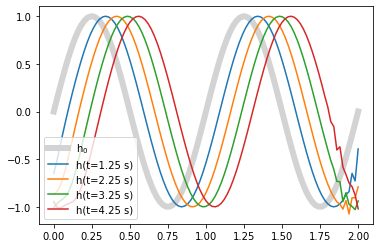

In [3]:
# FTCS scheme
# start time
time   = 0
dtplot = 1.00
tplot  = dtplot
# initial values
h = np.sin(2*np.pi*x)
plt.plot(x,h,linewidth=6,color='lightgray',label='h$_0$')

# solution
while (time < T):
    time = time + dt
    ### PERIODIC BC ###
    h[0]  = h[-2]
    h[-1] = h[1]
    hold = h
    for i in range(1,h.shape[0]-1):
        h[i] = hold[i] - u*dt/2/dx*(hold[i+1]-hold[i-1])
    if (time > tplot):
        plt.plot(x,h,label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

**Problem:** 
The use of the forward value $h_{i+1}^{n}$ in space uses
a value we do not know.

----
### Upwind finite differences

We rewrite the partial differential equation into **finite differences**,
with forward differences in time (FT), and backward differences in space (BS),
a scheme called **upwind**:
$$
\frac{h_{i}^{n+1}-h_{i}^{n}}{\Delta t}
+ u \frac{h_{i}^{n}-h_{i-1}^{n}}{\Delta x}
\simeq 0, \quad u>0
$$
<img style="height: 200px;" src="images/1Dcoord_upwind.jpg">
which can be recasted into the scheme:
$$
h_{i}^{n+1} \simeq h_{i}^{n}
- u \frac{\Delta t}{\Delta x} \left( h_{i}^{n}-h_{i-1}^{n} \right)
$$

**Note:** This upwind scheme is for $u>0$, for $u<0$ we would need a forward difference ...

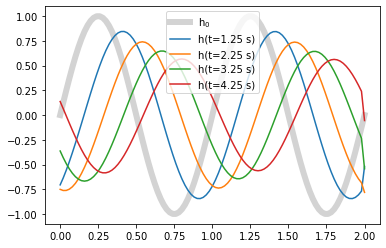

In [4]:
# Upwind scheme
# start time
time   = 0
dtplot = 1.00
tplot  = dtplot
# initial values
h = np.sin(2*np.pi*x)
plt.plot(x,h,linewidth=6,color='lightgray',label='h$_0$')

# solution
while (time < T):
    time = time + dt
    ### PERIODIC BC ###
    h[0]  = h[-2]
    h[-1] = h[1]
    hold = h
    for i in range(1,h.shape[0]-1):
        h[i] = hold[i] - u*dt/dx*(hold[i]-hold[i-1])
    if (time > tplot):
        plt.plot(x,h,label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

**Problem:**
Stable, but numerical diffusion.

----
### Finite-volume Gondurov scheme with Rosanov flux

We reformulate the partial differential equation into a pseudo-non-linear
one:
$$
\frac{\partial h}{\partial t}
+ \frac{\partial (hu)}{\partial x} = 0
$$
and we identify the term $hu$ as flux term:
$$
f(u) = h u
$$
<img style="height: 200px;" src="images/1Dcoord_LLF.jpg">

For the **finite volume method**, we integrate over one cell:
$$
\int\limits_{t_{n}}^{t_{n+1}}
\int\limits_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}}
\frac{\partial h}{\partial t}
+ \frac{\partial (hu)}{\partial x} dx dt = 0
$$
Integrate by parts:
$$
\int\limits_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}}
h(x,t^{n+1}) - h(x,t^{n}) dx 
+
\int\limits_{t_{n}}^{t_{n+1}}
f(x_{i+\frac{1}{2}},t) - f(x_{i-\frac{1}{2}},t)dt
= 0
$$
Final integration:
$$
\Delta x \left( h_{i}^{n+1} - h_{i}^{n} \right)
+ \Delta t \left( F_{i+\frac{1}{2}} - F_{i-\frac{1}{2}} \right) = 0
$$





Rewriting the non-linear partial differential equation into
$$
h_{i}^{n+1} \simeq h_{i}^{n}
- \frac{\Delta t}{\Delta x} \left( F_{i+\frac{1}{2}} - F_{i-\frac{1}{2}} \right)
$$
with the **Rosanov fluxes** $F_{i+\frac{1}{2}}$ and $F_{i-\frac{1}{2}}$ calculated
at the cell interfaces:
$$
F_{i+\frac{1}{2}} =
\frac{1}{2} \left[ f(h_i^n) + f(h_{i+1}^n) \right]
- \frac{\lambda_{max}}{2} \left( h_{i+1}^{n} - h_{i}^{n} \right)
$$
The eigen value $\lambda_{max}$ is
- $\lambda_{max}=u$ for linear advection,
- $\lambda_{max}=\max(f(u))$ for non-linear advection.

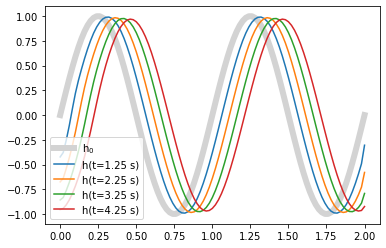

In [5]:
# Finite volume with Rusanov flux scheme
# start time
time   = 0
dtplot = 1.00
tplot  = dtplot
# initial values
h = np.sin(2*np.pi*x)
plt.plot(x,h,linewidth=6,color='lightgray',label='h$_0$')

# solution
while (time < T):
    time = time + dt
    ### PERIODIC BC ###
    h[0]  = h[-2]
    h[-1] = h[1]
    
    Fhup = h[1:]*u
    Fhum = h[:-1]*u
    Rh   = (Fhup+Fhum)/2 - u/2*(h[1:]-h[:-1])
    h[1:-1] = h[1:-1] - dt/dx*(Rh[1:]-Rh[:-1])
    if (time > tplot):
        plt.plot(x,h,label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

----
### 2. Example

Consider the initial condition
$$
h(x,t=0) = e^{-\frac{(x-\mu)^2}{\sigma^2}}, \quad x \in [0,10]
$$
with $\mu=2$ and $\sigma=1$.

We want to solve for $h(x,t)$ for $t \in [0,T]$.

In [6]:
nx = 101
xmin = 0
xmax = 10
T    = 5
x = np.linspace(xmin,xmax,nx)
dt = 0.05
dx = (x.max()-x.min()) / (nx-1)
u  = 0.5 # and test with u=1!!!
g  = 9.81
mu = 2
sigma = 1

print("dx: ",dx," dt: ",dt," u: ",u)
#print(x)
Courant = u*dt/dx
print ('Courant number: ',Courant)

dx:  0.1  dt:  0.05  u:  0.5
Courant number:  0.25


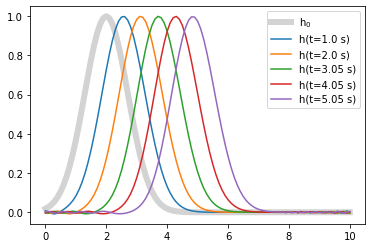

In [7]:
# FTCS scheme
# start time
time   = 0
dtplot = 1.00
tplot  = dtplot
# initial values
h = np.exp(-(x-mu)**2/sigma**2)
plt.plot(x,h,linewidth=6,color='lightgray',label='h$_0$')

# solution
while (time < T):
    time = time + dt
    ### PERIODIC BC ###
    h[0]  = h[-2]
    h[-1] = h[1]
    hold = h
    for i in range(1,h.shape[0]-1):
        h[i] = hold[i] - u*dt/2/dx*(hold[i+1]-hold[i-1])
    if (time > tplot):
        plt.plot(x,h,label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

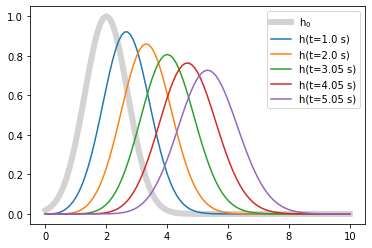

In [8]:
# Upwind scheme
# start time
time   = 0
dtplot = 1.00
tplot  = dtplot
# initial values
h = np.exp(-(x-mu)**2/sigma**2)
plt.plot(x,h,linewidth=6,color='lightgray',label='h$_0$')

# solution
while (time < T):
    time = time + dt
    ### PERIODIC BC ###
    h[0]  = h[-2]
    h[-1] = h[1]
    hold = h
    for i in range(1,h.shape[0]-1):
        h[i] = hold[i] - u*dt/dx*(hold[i]-hold[i-1])
    if (time > tplot):
        plt.plot(x,h,label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

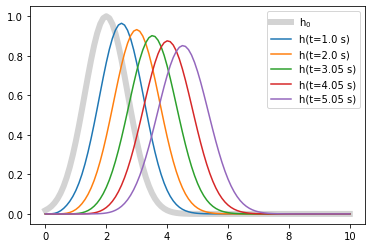

In [9]:
# Finite volume with Rusanov flux scheme
# start time
time   = 0
dtplot = 1.00
tplot  = dtplot
# initial values
h = np.exp(-(x-mu)**2/sigma**2)
plt.plot(x,h,linewidth=6,color='lightgray',label='h$_0$')

# solution
while (time < T):
    time = time + dt
    ### PERIODIC BC ###
    h[0]  = h[-2]
    h[-1] = h[1]
    
    Fhup = h[1:]*u
    Fhum = h[:-1]*u
    Rh   = (Fhup+Fhum)/2 - u/2*(h[1:]-h[:-1])
    h[1:-1] = h[1:-1] - dt/dx*(Rh[1:]-Rh[:-1])
    if (time > tplot):
        plt.plot(x,h,label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

... done